<a href="https://colab.research.google.com/github/CoGian/Detection-of-toxic-comments-and-minimization-of-unintended-model-bias-using-neural-networks/blob/master/RoBERTa_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
!pip install transformers 
from transformers import *
print(tf.__version__)
import numpy as np
import gc
import sys
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/tools')
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification')
from tools_benchmark import  compute_bias_metrics_for_model, calculate_overall_auc,get_final_metric
from tools_evaluate_model import evaluate

     |████████████████████████████████| 778kB 3.3MB/s 
     |████████████████████████████████| 890kB 12.1MB/s 
     |████████████████████████████████| 3.0MB 21.5MB/s 
     |████████████████████████████████| 1.1MB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=af36e5ab8f64e71a5566335545639c960add029552f74a063f94c281b9c5e40b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
2.3.0


# TPU Configs

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.93.110.26:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.93.110.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.110.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Load Datasets

In [ ]:
 IDENTITY_COLUMNS  = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
  ] 
TARGET_COLUMN = 'target'
TOXICITY_COLUMN = 'toxicity'
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

In [ ]:
test_public_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_cleared.csv")
#test_public_df = test_public_df.loc[:, ['toxicity','comment_text']  + IDENTITY_COLUMNS ].dropna()[:1000]
test_private_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_cleared.csv")
#test_private_df = test_private_df.loc[:, ['toxicity', 'comment_text'] + IDENTITY_COLUMNS ].dropna()[:1000]

In [ ]:
y_public_test = test_public_df[TOXICITY_COLUMN].values.reshape((-1,1))
y_private_test = test_private_df[TOXICITY_COLUMN].values.reshape((-1,1))

# Get datasets



In [ ]:
def get_dataset(PATH,forTest = False):
  
  with open('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/data/'+PATH+'/input_ids.npy','rb') as f:
    input_ids = np.load(f)

  with open('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/data/'+PATH+'/input_mask.npy','rb') as f:
    attention_mask = np.load(f)


  if(forTest):
    return tf.data.Dataset.from_tensor_slices({"input_word_ids" : input_ids , "input_mask" :attention_mask }).batch(BATCH_SIZE)
  else :
    with open('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/data/'+PATH+'/labels.npy','rb') as f:
      labels = np.load(f)
    with open('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/data/'+PATH+'/labels_aux.npy','rb') as f:
      labels_aux =np.load(f)
    with open('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/data/'+PATH+'/sample_weights.npy','rb') as f:
      sample_weights = np.load(f)
    return tf.data.Dataset.from_tensor_slices(({"input_word_ids" : input_ids , "input_mask" : attention_mask}
                                                    ,{"target": labels, "aux": labels_aux},sample_weights ))
                                                    

# RoBERTa-with-max-avg-pool

## Create Model

In [ ]:
def createRoBERTa(roberta_layer):
  input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                   name="input_mask")
  
  sequence_output , pooled_output = roberta_layer([input_word_ids, input_mask])

  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(sequence_output)
  x = tf.keras.layers.concatenate([avg_pool,max_pool])
  

  x = tf.keras.layers.Dropout(0.2)(x)
  
  result = tf.keras.layers.Dense(1, activation="sigmoid", name="target")(x)
  aux_result =  tf.keras.layers.Dense(6, activation='sigmoid' , name = 'aux')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=[result, aux_result])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),metrics = ['accuracy'])
  return model

## RoBERTa - base

In [ ]:
BATCH_SIZE = 64 
EPOCHS = 4
MAX_LEN = 180
BUFFER_SIZE =  np.ceil(1804874 * 0.8)
MODEL = 'roberta-base'

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
train_inputs_ds = get_dataset('train').repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
gc.collect()
val_inputs_ds = get_dataset('val').batch(BATCH_SIZE).cache().prefetch(AUTO)
gc.collect()
test_public_inputs_ds = get_dataset('test_public',forTest = True)
gc.collect()
test_private_inputs_ds = get_dataset('test_private',forTest = True)
gc.collect()

6

- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 180)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 180)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo ((None, 180, 768), ( 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_roberta_model_1[0][

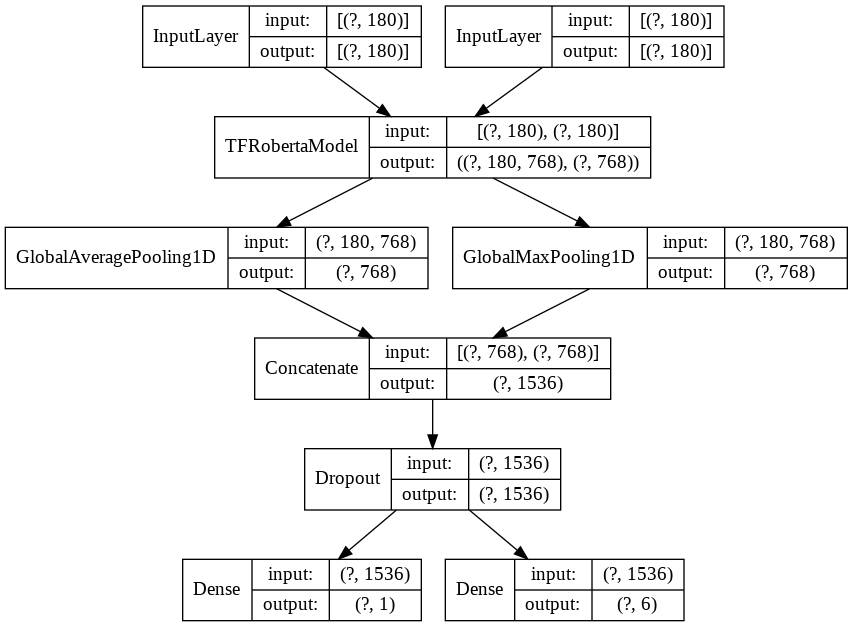

In [ ]:
with strategy.scope():
  roberta_layer = TFAutoModel.from_pretrained(MODEL)
  model = createRoBERTa(roberta_layer)
model.summary()
tf.keras.utils.plot_model(model, show_shapes= True ,show_layer_names=False, 
                  to_file='/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/RoBERTa/RoBERTa-with-max-avg-pool/RoBERTawPOOL.png')

In [ ]:
n_steps = BUFFER_SIZE // BATCH_SIZE 
for epoch in range(EPOCHS):
  model.fit(x = train_inputs_ds,validation_data=val_inputs_ds , epochs = 1 
                          ,verbose = 1 , steps_per_epoch=n_steps )
  y_public_pred  = model.predict(test_public_inputs_ds, verbose=1 )
  y_private_pred = model.predict(test_private_inputs_ds, verbose=1 )
  evaluate(y_public_pred[0],y_private_pred[0], test_public_df, test_private_df, 'RoBERTa/RoBERTa-with-max-avg-pool/' + str(epoch+1) + '_epochs' , MODEL)

1521/1521 [==============================] - 72s 47ms/step
Accuracy on public test: 0.941132
Accuracy on private test: 0.941934
Public AUC score : 0.941909
Private AUC score : 0.941982
1521/1521 [==============================] - 71s 47ms/step
Accuracy on public test: 0.946465
Accuracy on private test: 0.946301
Public AUC score : 0.945036
Private AUC score : 0.943449
1521/1521 [==============================] - 73s 48ms/step
Accuracy on public test: 0.953566
Accuracy on private test: 0.953905
Public AUC score : 0.943140
Private AUC score : 0.941506
1521/1521 [==============================] - 71s 47ms/step
Accuracy on public test: 0.953802
Accuracy on private test: 0.953247
Public AUC score : 0.943298
Private AUC score : 0.941226
